In [58]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns


In [59]:
df = pd.read_csv('data_pre_process.csv', index_col = 0)
df.head()

,designation,description,productid,imageid,prdtypecode,lang_designation,lang_description,designation_in_description_ratio,description_complete,lang_description_complete,description_complete_length
0,olivia personalisiertes notizbuch seiten punkt...,olivia personalisiertes notizbuch seiten punkt...,3804725264,1263597046,10,de,de,1.0,olivia personalisiertes notizbuch seiten punkt...,de,59
1,journal art marche salon asiatique paris jacqu...,journal art marche salon asiatique paris jacqu...,436067568,1008141237,2280,fr,fr,1.0,journal art marche salon asiatique paris jacqu...,fr,119
2,grand stylet ergonomique bleu gamepad nintendo...,pilot style touch pen marque speedlink stylet ...,201115110,938777978,50,en,fr,1.0,grand stylet ergonomique bleu gamepad nintendo...,fr,567
3,peluche donald europe disneyland marionnette d...,peluche donald europe disneyland marionnette d...,50418756,457047496,1280,fr,fr,1.0,peluche donald europe disneyland marionnette d...,fr,50
4,guerre tuques,luc idées grandeur veut organiser jeu guerre b...,278535884,1077757786,2705,fr,fr,0.5,guerre tuques luc idées grandeur veut organise...,fr,118


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78822 entries, 0 to 84915
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   designation                       78792 non-null  object 
 1   description                       78654 non-null  object 
 2   productid                         78822 non-null  int64  
 3   imageid                           78822 non-null  int64  
 4   prdtypecode                       78822 non-null  int64  
 5   lang_designation                  78822 non-null  object 
 6   lang_description                  78822 non-null  object 
 7   designation_in_description_ratio  78822 non-null  float64
 8   description_complete              78821 non-null  object 
 9   lang_description_complete         78822 non-null  object 
 10  description_complete_length       78822 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 7.2+ MB


In [61]:
df['class']= df['prdtypecode'].replace(list(df['prdtypecode'].unique()), [i for i in range(27)])
df = df[['class', 'description_complete', 'description_complete_length']]

df = df.dropna()

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78821 entries, 0 to 84915
Data columns (total 3 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   class                        78821 non-null  int64 
 1   description_complete         78821 non-null  object
 2   description_complete_length  78821 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.4+ MB


/var/folders/8_/rts9h4kn0g9ftjd7qn06h2t80000gn/T/ipykernel_99227/4045688724.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(compteur_mot)


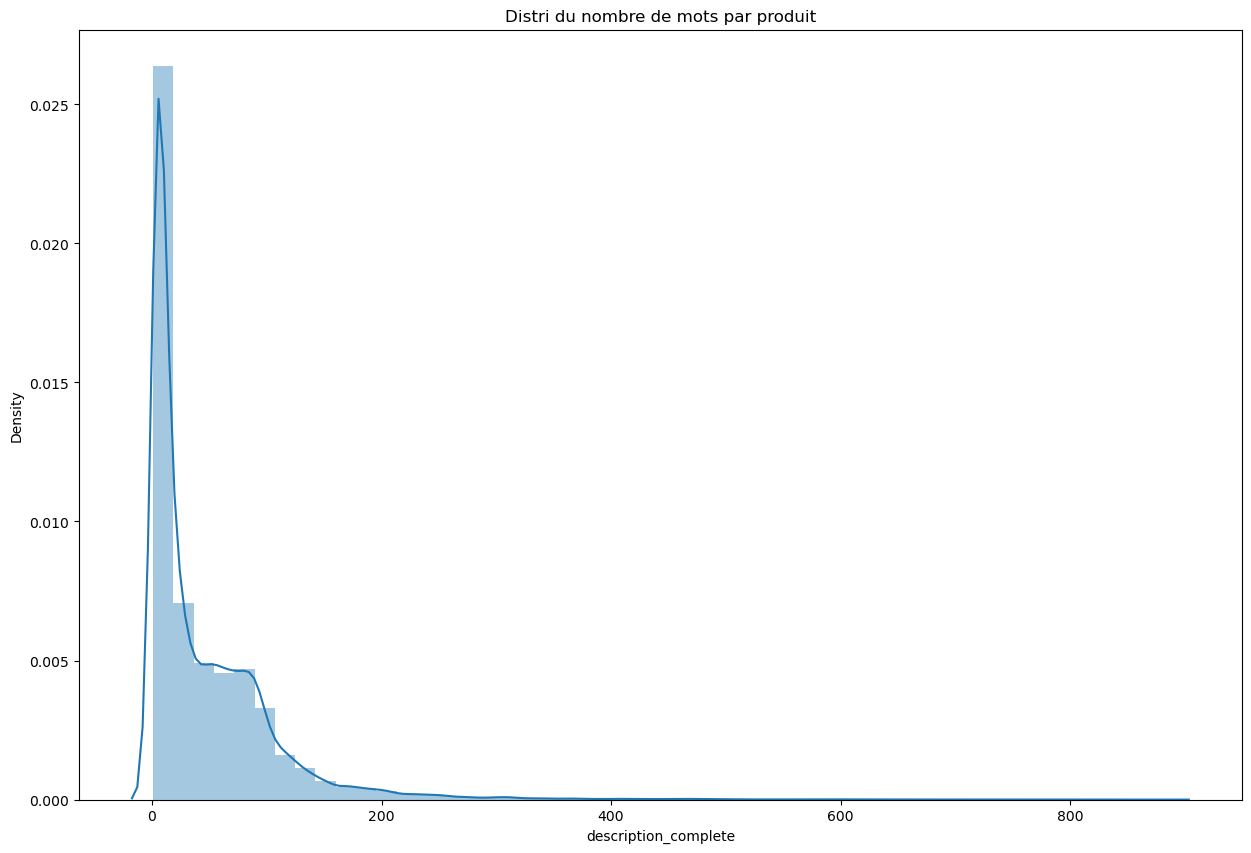

In [62]:
compteur_mot = df.description_complete.apply(lambda x : len(x.split(' ')))
plt.figure(figsize = (15,10))
sns.distplot(compteur_mot)
#sns.distplot(df['description_complete_length'])
plt.title("Distri du nombre de mots par produit")
plt.show()

In [63]:
print("95% des lignes contiennent moins de {} mots ." .format(compteur_mot.quantile(0.95)))
print(max(compteur_mot))

# On gardera une séquence de 150 mots.

95% des lignes contiennent moins de 145.0 mots .
885


In [64]:
# Détermination du nombre de mots nécessaires pour couvrir 95% des occurrences (des mots)
# On détermine max_words (le max de mots uniques que le tokenier doit prendre en compte)

from collections import Counter

# Fonction tokenisation simple
def tokenize(texts):
    tokenized_texts = []
    for text in texts:
        tokens = text.lower().split()
        tokenized_texts.append(tokens)
    return tokenized_texts

# App sur la col description_complete
token_desc = tokenize(df['description_complete'])

# liste de tous les tokens
all_tokens = [token for sublist in token_desc for token in sublist]

# comptage
token_counts = Counter(all_tokens)

# trier par distri (en fonction de la deuxième valeur de chaque tuple, ordre décroissant)
sorted_tokens = sorted(token_counts.items(), key=lambda item: item[1], reverse=True)

# Cover cumulative des tokens
cumul_cov = np.cumsum([count for _, count in sorted_tokens]) / len(all_tokens)

# Nombre de tokens nécessaires pour une couverture de 95%
token_95 = next(i for i, cov in enumerate(cumul_cov) if cov >= 0.95) + 1

token_95

# Nous pourrons partir sur une longueur max des séquences pour notre modèle de 26 707, 
#puis augmenter à 30 000 pour voir s'il y a une amélioration de l'accuracy

26707

In [65]:
X = df['description_complete'].values
y = df['class'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [66]:
# tokenization

max_words = token_95 # max de mots uniques que le tokenizer doit prendre en compte
# tokénization
tokenizer = Tokenizer(num_words=max_words,lower=True)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_len = 150 # longueur max des séquences (relatives à la distribution des séquence du graph ci-dessus)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

In [67]:
# architecture
model = Sequential() # création du modèle de réseau séquentiel

model.add(Embedding(input_dim = max_words, output_dim = 50, input_length = max_len)) # Dimension réduite pour l'embedding
# input_dim = nombre max de mots uniques
# output_dim = dim de l'embedding pour chaque mot
# input_length = longueur max des séquences
"""L'embedding est une représentation dense et de dimension réduite des tokens d'un texte. 
Cette couche transforme les entiers positifs (index de mots) en vecteurs de dimension fixe.
elle permet de représenter les mots de manière dense et significative, 
facilitant ainsi l'apprentissage et la généralisation du modèle"""

model.add(Dropout(0.2))  # Dropout pour réduire le surajustement
"""une technique de régularisation qui consiste à désactiver aléatoirement un pourcentage des neurones 
pendant l'entraînement pour éviter le surapprentissage."""
# Ici nous avons mis une désactivation aléatoire à hauteur de 20% des neurones

model.add(GlobalMaxPooling1D())  # Réduction de la dimensionnalité et abstraction des features
"""réduit la dimensionnalité des tenseurs en prenant la valeur maximale sur chaque dimension. 
Cela permet d'abstraire les features les plus importantes et de réduire la dimensionnalité des données.
On prend les meilleures couleurs pour la peinture"""

model.add(Dense(50, activation='relu'))  # Couche Dense
# activation = 'relu' (valeurs neg --> 0)
"""On connecte chaque bloc à tous les autres de l'étape précédente, avec la règle relu, c'est une étape de construction"""

model.add(Dropout(0.2))  # une autre couche de dropout pour plus de régularisation (toujours à 20%)

model.add(Dense(len(np.unique(y_train)), activation='softmax'))  # Sortie avec activation softmax pour la classification
# activation = 'softmax' (donne une proba en sortie pour chaque classe, somme des probas bien evidemment = 1)
# Compilation du modèle
"""couche Dense à la sortie du modèle, avec un nombre de neurones égal au nombre de classes dans nos données de sortie
"""

# compilation du modèle
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
# optimizer = 'adam' minimise la fonction de perte
# loss = 'sparse_categorical_crossentropy' fonction de perte utilisé pour evaluation des perfs du modèle
# metrics = ['accuracy'] La métrique que nous comparerons pour évaluer le modèle

model.summary() # résumé du modèle 1

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 150, 50)           1335350   
                                                                 
 dropout_8 (Dropout)         (None, 150, 50)           0         
                                                                 
 global_max_pooling1d_4 (Gl  (None, 50)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_10 (Dense)            (None, 50)                2550      
                                                                 
 dropout_9 (Dropout)         (None, 50)                0         
                                                                 
 dense_11 (Dense)            (None, 27)                1377      
                                                      

Epoch 1/5
1971/1971 - 9s - loss: 1.8561 - accuracy: 0.4713 - val_loss: 1.2013 - val_accuracy: 0.6666 - 9s/epoch - 4ms/step
Epoch 2/5
1971/1971 - 9s - loss: 1.0762 - accuracy: 0.6851 - val_loss: 0.9725 - val_accuracy: 0.7245 - 9s/epoch - 4ms/step
Epoch 3/5
1971/1971 - 8s - loss: 0.8716 - accuracy: 0.7436 - val_loss: 0.9020 - val_accuracy: 0.7350 - 8s/epoch - 4ms/step
Epoch 4/5
1971/1971 - 8s - loss: 0.7657 - accuracy: 0.7741 - val_loss: 0.8742 - val_accuracy: 0.7394 - 8s/epoch - 4ms/step
Epoch 5/5
1971/1971 - 8s - loss: 0.6890 - accuracy: 0.7941 - val_loss: 0.8602 - val_accuracy: 0.7442 - 8s/epoch - 4ms/step
493/493 [==============================] - 0s 375us/step - loss: 0.8602 - accuracy: 0.7442
Test accuracy: 0.7442435622215271


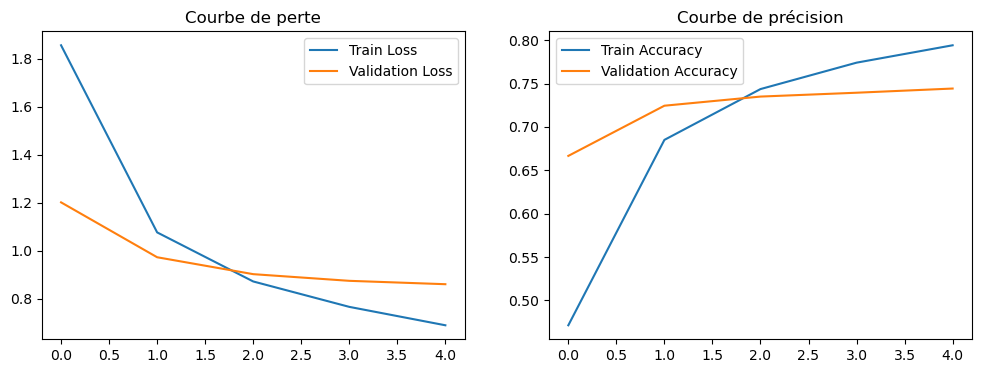

In [68]:
# Entraînement du modèle

epochs = 5
# epochs : le modèle sera entraîné sur l'ensemble des données d'entraînement cinq fois
batch_size = 32
# batch_size : chaque mise à jour des poids sera basée sur un batch de 32 échantillons

history = model.fit(
    X_train_pad, y_train,
    epochs = epochs,
    batch_size = batch_size,
    validation_data=(X_test_pad, y_test),
    verbose=2
)

# evaluation modèle sur les données test
score = model.evaluate(X_test_pad, y_test, verbose=1)
print("Test accuracy:", score[1])


# Visualisation des résultats
plt.figure(figsize=(12, 4))

# Tracer la courbe de perte
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Courbe de perte')
plt.legend()

# Tracer la courbe de précision
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Courbe de précision')
plt.legend()

plt.show()


Les courbes nous montrent que le modèle s'améliore de manière constante tout au long de l'entrainement.

La courbe de perte :
La courbe de perte d'entraînement diminue constamment, ce qui est un bon signe et montre que le modèle apprend et s'améliore à chaque epoch.
La courbe de perte de validation diminue également, ce qui indique que le modèle est en train de généraliser plutôt que de surajuster.

La courbe de Précision :
La précision d'entraînement augmente de manière constante, ce qui est attendu.
La précision de validation augmente également, ce qui suggère que les améliorations de l'apprentissage se généralisent aux données non vues.

Il n'y a pas de grands écarts entre les courbes de formation et de validation, ce qui est généralement un bon indicateur qu'il n'y a pas de surajustement significatif.
La précision de test finale de 74.61% est assez proche de la précision de validation, ce qui suggère que le modèle évalué est performant et fiable.

Ancienne évaluation :
La précision sur l'ensemble d'entraînement a augmenté de manière stable de 44.92% à 78.81% au cours des 5 époques, ce qui est un bon signe que le modèle apprend efficacement à partir des données.

La précision sur l'ensemble de validation/test a également augmenté pour atteindre 74.10%, ce qui indique que le modèle généralise bien à des données qu'il n'a pas vues pendant l'entraînement.

--> augmentation du nombre d'epochs, utilisation de EarlyStopping et ModelCheckPoint pour surveiller et save les meilleurs modèles.

Epoch 1/20

Epoch 1: val_loss improved from inf to 0.86115, saving model to meilleur_modele.h5
1971/1971 - 8s - loss: 0.6419 - accuracy: 0.8076 - val_loss: 0.8611 - val_accuracy: 0.7437 - 8s/epoch - 4ms/step
Epoch 2/20


/Users/shawnspenstar/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss did not improve from 0.86115
1971/1971 - 9s - loss: 0.6041 - accuracy: 0.8192 - val_loss: 0.8636 - val_accuracy: 0.7458 - 9s/epoch - 5ms/step
Epoch 3/20

Epoch 3: val_loss did not improve from 0.86115
1971/1971 - 8s - loss: 0.5722 - accuracy: 0.8272 - val_loss: 0.8700 - val_accuracy: 0.7461 - 8s/epoch - 4ms/step
Epoch 4/20
Restoring model weights from the end of the best epoch: 1.

Epoch 4: val_loss did not improve from 0.86115
1971/1971 - 8s - loss: 0.5530 - accuracy: 0.8322 - val_loss: 0.8758 - val_accuracy: 0.7453 - 8s/epoch - 4ms/step
Epoch 4: early stopping
493/493 [==============================] - 0s 355us/step - loss: 0.8611 - accuracy: 0.7437
Précision sur les données de test : 0.7436726689338684


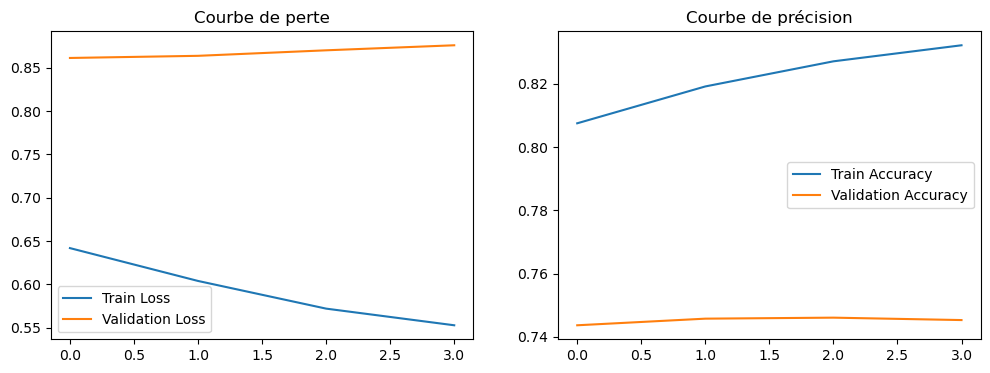

In [69]:
# augmentation de nombre d'epochs et EarlyStopping/ModelCheckpoint
epochs = 20

# EarlyStopping
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, verbose = 1, mode = 'min', 
                               restore_best_weights = True)
"""permet d'arrêter automatiquement l'entraînement du modèle si certaines conditions sont remplies. 
Afin d'éviter le surapprentissage et à économiser du temps de calcul."""
# monitor = 'val_loss' Nous sruveillons la perte, l'entraînement s'arrêtera lorsque la perte sur l'ensemble de validation cessera de diminuer
# patience = 3 si la perte sur l'ensemble de validation ne diminue pas pendant trois epochs consécutives, l'entraînement s'arrêtera
# verbose = 1 niveau de détail des informations affichées pendant l'entraînement
# mode = 'min' sens dans lequel nous souhaitons interpreter la métrique (ici minimiser la perte)
# restore_best_weights = True les poids seront restaurés à ceux qui ont produit la perte de validation la plus basse

# ModelCheckpoint
model_checkpoint = ModelCheckpoint('meilleur_modele.h5', monitor = 'val_loss', mode = 'min', 
                                   save_best_only = True, verbose = 1)
"""fonction qui sauvegarde les poids du modèle à chaque epoch si la perte sur l'ensemble de validation atteint un minimum. 
Cela permet de conserver les poids du modèle qui produisent la meilleure performance sur les données de validation, 
ce qui est utile pour éviter de perdre des améliorations de performance pendant l'entraînement."""
# 'meilleur_modele.h5'nom du fichier dans lequel les poids du modèle seront sauvegardés
# save_best_only = True seuls les poids qui correspondent au minimum de la perte sur l'ensemble de validation seront sauvegardés

history = model.fit(
    X_train_pad, y_train,
    epochs=epochs,
    batch_size=32,
    validation_data=(X_test_pad, y_test),
    callbacks=[early_stopping, model_checkpoint],
    verbose=2
)

# Évaluation du modèle
# Ici, le modèle chargé sera celui qui a performé le mieux sur l'ensemble de validation
model.load_weights('meilleur_modele.h5')
score = model.evaluate(X_test_pad, y_test, verbose=1)
print("Précision sur les données de test :", score[1])

# Visualisation des résultats
plt.figure(figsize=(12, 4))

# Tracer la courbe de perte
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Courbe de perte')
plt.legend()

# Tracer la courbe de précision
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Courbe de précision')
plt.legend()

plt.show()



Courbes de Perte :
La perte d'entraînement diminue continuellement, ce qui est un bon signe d'apprentissage.
La perte de validation, après avoir légèrement diminué à la première époque, commence à augmenter légèrement aux époques suivantes. Cela peut indiquer que le modèle commence à surajuster après la première époque.

Courbes de Précision :
La précision d'entraînement augmente progressivement, ce qui indique que le modèle continue d'apprendre.
La précision de validation, après avoir augmenté initialement, reste stable ou diminue légèrement. Ce plateau dans la précision de validation suggère que le modèle ne parvient pas à améliorer ses performances sur les nouvelles données après la première époque.

Analyse des Époques :
Le modèle a atteint la meilleure perte de validation à la première époque et n'a pas réussi à améliorer cette performance dans les époques suivantes, ce qui a déclenché l'arrêt précoce. Cela signifie que l'augmentation du nombre d'époques n'a pas été bénéfique pour l'amélioration du modèle avec la configuration actuelle.

Surajustement :
Bien que l'augmentation de la perte de validation ne soit pas très prononcée, le fait que la précision de validation ne s'améliore pas tandis que la précision d'entraînement continue d'augmenter est un signe de surajustement. Le modèle apprend des spécificités des données d'entraînement qui ne se généralisent pas aux données de validation.

Nous allons augmenter le dropout pour palier au surajustement

Epoch 1/5
1971/1971 - 10s - loss: 2.1830 - accuracy: 0.3621 - val_loss: 1.6411 - val_accuracy: 0.6068 - 10s/epoch - 5ms/step
Epoch 2/5
1971/1971 - 9s - loss: 1.5029 - accuracy: 0.5519 - val_loss: 1.3520 - val_accuracy: 0.6699 - 9s/epoch - 5ms/step
Epoch 3/5
1971/1971 - 9s - loss: 1.3143 - accuracy: 0.6068 - val_loss: 1.1864 - val_accuracy: 0.7046 - 9s/epoch - 4ms/step
Epoch 4/5
1971/1971 - 8s - loss: 1.2116 - accuracy: 0.6361 - val_loss: 1.1111 - val_accuracy: 0.7168 - 8s/epoch - 4ms/step
Epoch 5/5
1971/1971 - 8s - loss: 1.1475 - accuracy: 0.6548 - val_loss: 1.0628 - val_accuracy: 0.7235 - 8s/epoch - 4ms/step
493/493 [==============================] - 0s 349us/step - loss: 1.0628 - accuracy: 0.7235
Test accuracy: 0.723501443862915


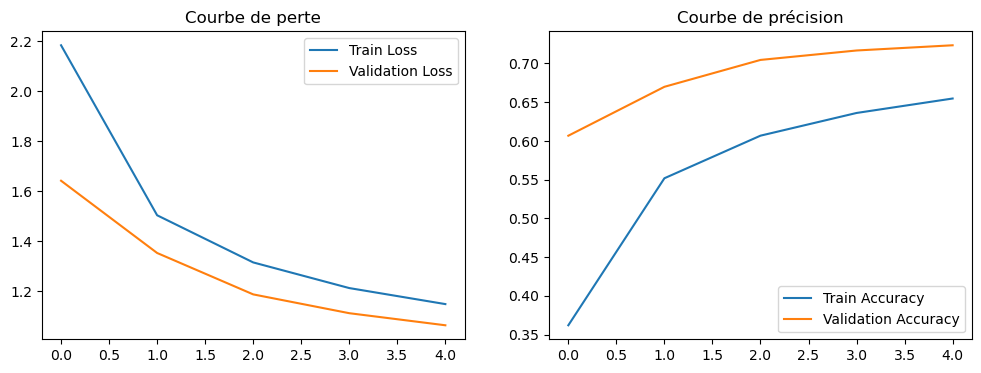

In [73]:
# augmentation du dropout pour palier le surajustement et remise du nombre d'epochs à 5
epochs = 5
dropout_rate = 0.5

# maj de l'architecture du modele
model = Sequential()
model.add(Embedding(input_dim = max_words, output_dim = 50, input_length = max_len))
model.add(Dropout(dropout_rate))
model.add(GlobalMaxPooling1D())
model.add(Dense(50, activation = 'relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(len(np.unique(y_train)), activation='softmax'))

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, verbose = 1, mode = 'min', 
                               restore_best_weights = True)

history = model.fit(
    X_train_pad, y_train,
    epochs = epochs,
    batch_size = 32,
    validation_data = (X_test_pad, y_test),
    callbacks = [early_stopping],  
    verbose = 2
)

# evaluation modèle sur les données test
score = model.evaluate(X_test_pad, y_test, verbose=1)
print("Test accuracy:", score[1])


# Visualisation des résultats
plt.figure(figsize=(12, 4))

# Tracer la courbe de perte
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Courbe de perte')
plt.legend()

# Tracer la courbe de précision
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Courbe de précision')
plt.legend()

plt.show()

Courbe de Perte (Loss) :
La perte d'entraînement a considérablement diminué au fil des époques, ce qui montre que le modèle apprend efficacement.
La perte de validation a également diminué à chaque époque, ce qui indique que le modèle s'améliore également sur les données qu'il n'a pas vues pendant l'entraînement.

Courbe de Précision (Accuracy) :
La précision d'entraînement a augmenté de manière régulière, ce qui est un bon signe.
La précision de validation a également augmenté à chaque époque, ce qui suggère que le modèle généralise bien. Il n'y a pas de divergence significative entre la précision d'entraînement et de validation, ce qui est généralement un indicateur de l'absence de surajustement.

Analyse Générale :
Aucun signe évident de surajustement n'est présent, puisque les deux courbes de perte et de précision montrent des améliorations cohérentes.
L'augmentation du taux de dropout semble avoir un effet positif sur la capacité du modèle à généraliser, comme le montre l'amélioration de la précision de validation.

Réessayons de réaugmenter le nombre d'epochs à 20

Epoch 1/20
1971/1971 - 8s - loss: 2.1652 - accuracy: 0.3689 - val_loss: 1.5866 - val_accuracy: 0.6176 - 8s/epoch - 4ms/step
Epoch 2/20
1971/1971 - 8s - loss: 1.4398 - accuracy: 0.5673 - val_loss: 1.2588 - val_accuracy: 0.6935 - 8s/epoch - 4ms/step
Epoch 3/20
1971/1971 - 8s - loss: 1.2572 - accuracy: 0.6231 - val_loss: 1.1469 - val_accuracy: 0.7137 - 8s/epoch - 4ms/step
Epoch 4/20
1971/1971 - 8s - loss: 1.1591 - accuracy: 0.6525 - val_loss: 1.0665 - val_accuracy: 0.7283 - 8s/epoch - 4ms/step
Epoch 5/20
1971/1971 - 9s - loss: 1.0991 - accuracy: 0.6696 - val_loss: 1.0308 - val_accuracy: 0.7297 - 9s/epoch - 5ms/step
Epoch 6/20
1971/1971 - 8s - loss: 1.0636 - accuracy: 0.6805 - val_loss: 1.0124 - val_accuracy: 0.7300 - 8s/epoch - 4ms/step
Epoch 7/20
1971/1971 - 9s - loss: 1.0296 - accuracy: 0.6887 - val_loss: 0.9921 - val_accuracy: 0.7333 - 9s/epoch - 4ms/step
Epoch 8/20
1971/1971 - 8s - loss: 1.0060 - accuracy: 0.6950 - val_loss: 0.9643 - val_accuracy: 0.7374 - 8s/epoch - 4ms/step
Epoch 9/

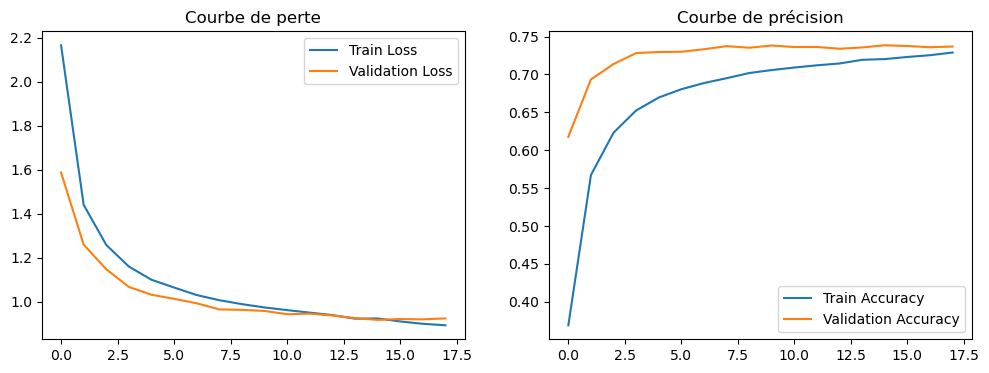

In [74]:
# augmentation du dropout pour palier le surajustement
epochs = 20
dropout_rate = 0.5

# maj de l'architecture du modele
model = Sequential()
model.add(Embedding(input_dim = max_words, output_dim = 50, input_length = max_len))
model.add(Dropout(dropout_rate))
model.add(GlobalMaxPooling1D())
model.add(Dense(50, activation = 'relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(len(np.unique(y_train)), activation='softmax'))

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, verbose = 1, mode = 'min', 
                               restore_best_weights = True)

history = model.fit(
    X_train_pad, y_train,
    epochs = epochs,
    batch_size = 32,
    validation_data = (X_test_pad, y_test),
    callbacks = [early_stopping],  
    verbose = 2
)

# evaluation modèle sur les données test
score = model.evaluate(X_test_pad, y_test, verbose=1)
print("Test accuracy:", score[1])


# Visualisation des résultats
plt.figure(figsize=(12, 4))

# Tracer la courbe de perte
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Courbe de perte')
plt.legend()

# Tracer la courbe de précision
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Courbe de précision')
plt.legend()

plt.show()

Courbe de Perte :
La perte d'entraînement diminue de manière continue et régulière, ce qui est un bon signe que le modèle apprend de manière stable à partir des données d'entraînement.
La perte de validation diminue également, mais avec un léger rebond après quelques époques. Cela peut indiquer que le modèle commence à atteindre ses limites de généralisation après un certain point.

Courbe de Précision :
La précision d'entraînement augmente régulièrement, indiquant un apprentissage cohérent.
La précision de validation suit la tendance de la précision d'entraînement, mais plafonne vers les dernières époques. Cela indique que le modèle ne s'améliore plus significativement sur les données de validation.

Évaluation de l'Early Stopping :
L'entraînement s'arrête après 18 époques, comme l'indique EarlyStopping, avec les meilleurs poids restaurés à partir de l'époque 15, ce qui suggère que c'était le point où le modèle avait la meilleure performance sur l'ensemble de validation.

Performance sur l'Ensemble de Test :
Une précision de test de 73.85% est assez proche de la précision de validation, indiquant une bonne généralisation du modèle.

--> Ajustement du nombre d'epochs à 15 et réduction de l'embedding pour ameliorer la précision

Epoch 1/15
1971/1971 - 7s - loss: 2.2551 - accuracy: 0.3293 - val_loss: 1.7447 - val_accuracy: 0.5640 - 7s/epoch - 4ms/step
Epoch 2/15
1971/1971 - 7s - loss: 1.5909 - accuracy: 0.5213 - val_loss: 1.4140 - val_accuracy: 0.6514 - 7s/epoch - 3ms/step
Epoch 3/15
1971/1971 - 7s - loss: 1.4018 - accuracy: 0.5776 - val_loss: 1.2749 - val_accuracy: 0.6803 - 7s/epoch - 3ms/step
Epoch 4/15
1971/1971 - 7s - loss: 1.2984 - accuracy: 0.6085 - val_loss: 1.1934 - val_accuracy: 0.6947 - 7s/epoch - 4ms/step
Epoch 5/15
1971/1971 - 8s - loss: 1.2390 - accuracy: 0.6291 - val_loss: 1.1462 - val_accuracy: 0.7066 - 8s/epoch - 4ms/step
Epoch 6/15
1971/1971 - 8s - loss: 1.1871 - accuracy: 0.6443 - val_loss: 1.1091 - val_accuracy: 0.7097 - 8s/epoch - 4ms/step
Epoch 7/15
1971/1971 - 7s - loss: 1.1584 - accuracy: 0.6519 - val_loss: 1.0903 - val_accuracy: 0.7154 - 7s/epoch - 4ms/step
Epoch 8/15
1971/1971 - 7s - loss: 1.1274 - accuracy: 0.6597 - val_loss: 1.0576 - val_accuracy: 0.7177 - 7s/epoch - 3ms/step
Epoch 9/

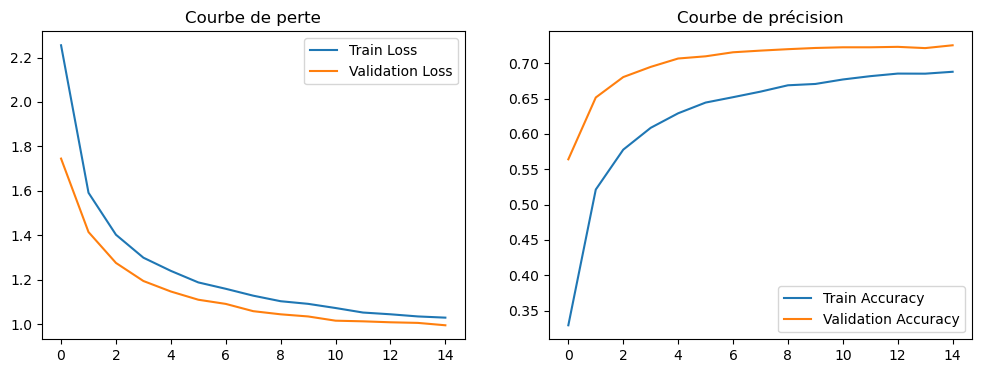

In [77]:
# augmentation du dropout pour palier le surajustement
epochs = 15
dropout_rate = 0.5
embedding_dim = 40

# maj de l'architecture du modele
model = Sequential()
model.add(Embedding(input_dim = max_words, output_dim = embedding_dim, input_length = max_len))
model.add(Dropout(dropout_rate))
model.add(GlobalMaxPooling1D())
model.add(Dense(50, activation = 'relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(len(np.unique(y_train)), activation='softmax'))

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, verbose = 1, mode = 'min', 
                               restore_best_weights = True)

history = model.fit(
    X_train_pad, y_train,
    epochs = epochs,
    batch_size = 32,
    validation_data = (X_test_pad, y_test),
    callbacks = [early_stopping], verbose = 2)

# evaluation modèle sur les données test
score = model.evaluate(X_test_pad, y_test, verbose=1)
print("Test accuracy:", score[1])


# Visualisation des résultats
plt.figure(figsize=(12, 4))

# Tracer la courbe de perte
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Courbe de perte')
plt.legend()

# Tracer la courbe de précision
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Courbe de précision')
plt.legend()

plt.show()

Courbe de Perte :
La perte d'entraînement continue de diminuer, ce qui indique que le modèle apprend de manière stable et efficace.
La perte de validation suit également une tendance à la baisse et ne montre pas d'augmentation notable, ce qui est un bon signe que le modèle ne surajuste pas.

Courbe de Précision :
La précision d'entraînement augmente progressivement, ce qui est le comportement attendu pendant l'apprentissage.
La précision de validation augmente également et ne semble pas plafonner, ce qui suggère que le modèle pourrait continuer à s'améliorer avec des époques supplémentaires ou d'autres ajustements.

Analyse Générale :
Il n'y a pas de signes clairs de surajustement ; les courbes de perte et de précision indiquent que le modèle bénéficie de chaque époque supplémentaire.
L'ajustement de la dimension de l'embedding à 40 n'a pas nuit à la capacité d'apprentissage du modèle et peut avoir contribué à une meilleure généralisation.

--> modification de la taille des batchs

Epoch 1/15
3941/3941 - 14s - loss: 2.1354 - accuracy: 0.3698 - val_loss: 1.6150 - val_accuracy: 0.6155 - 14s/epoch - 4ms/step
Epoch 2/15
3941/3941 - 14s - loss: 1.5301 - accuracy: 0.5394 - val_loss: 1.3357 - val_accuracy: 0.6790 - 14s/epoch - 4ms/step
Epoch 3/15
3941/3941 - 14s - loss: 1.3554 - accuracy: 0.5937 - val_loss: 1.2099 - val_accuracy: 0.6998 - 14s/epoch - 4ms/step
Epoch 4/15
3941/3941 - 16s - loss: 1.2655 - accuracy: 0.6197 - val_loss: 1.1422 - val_accuracy: 0.7077 - 16s/epoch - 4ms/step
Epoch 5/15
3941/3941 - 16s - loss: 1.2080 - accuracy: 0.6374 - val_loss: 1.0937 - val_accuracy: 0.7148 - 16s/epoch - 4ms/step
Epoch 6/15
3941/3941 - 14s - loss: 1.1697 - accuracy: 0.6496 - val_loss: 1.0477 - val_accuracy: 0.7184 - 14s/epoch - 4ms/step
Epoch 7/15
3941/3941 - 15s - loss: 1.1351 - accuracy: 0.6607 - val_loss: 1.0337 - val_accuracy: 0.7199 - 15s/epoch - 4ms/step
Epoch 8/15
3941/3941 - 15s - loss: 1.1084 - accuracy: 0.6681 - val_loss: 1.0237 - val_accuracy: 0.7177 - 15s/epoch - 4

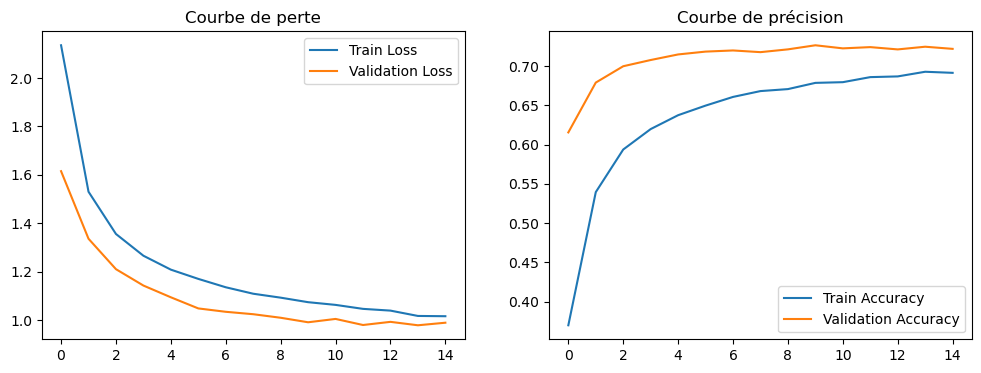

In [79]:
# modification de la taille des batchs

"""La taille du batch peut avoir un impact significatif sur la formation du modèle. 
Un batch plus petit donne généralement lieu à une mise à jour des poids plus fréquente, 
ce qui peut aider à apprendre des données plus détaillées, 
tandis qu'un batch plus grand offre une meilleure estimation de l'erreur sur l'ensemble du dataset, 
mais avec moins de mises à jour."""

# Nous allons tester avec un nombre plus petit et un nombre plus grand
# Batch_size = 16 (on divise par 2 sa valeur)

# augmentation du dropout pour palier le surajustement
epochs = 15
dropout_rate = 0.5
embedding_dim = 40
batch_size = 16

# maj de l'architecture du modele
model = Sequential()
model.add(Embedding(input_dim = max_words, output_dim = embedding_dim, input_length = max_len))
model.add(Dropout(dropout_rate))
model.add(GlobalMaxPooling1D())
model.add(Dense(50, activation = 'relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(len(np.unique(y_train)), activation='softmax'))

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, verbose = 1, mode = 'min', 
                               restore_best_weights = True)

history = model.fit(
    X_train_pad, y_train,
    epochs = epochs,
    batch_size = batch_size,
    validation_data = (X_test_pad, y_test),
    callbacks = [early_stopping], verbose = 2)

# evaluation modèle sur les données test
score = model.evaluate(X_test_pad, y_test, verbose=1)
print("Test accuracy:", score[1])


# Visualisation des résultats
plt.figure(figsize=(12, 4))

# Tracer la courbe de perte
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Courbe de perte')
plt.legend()

# Tracer la courbe de précision
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Courbe de précision')
plt.legend()

plt.show()

Courbe de Perte :
La perte d'entraînement a régulièrement diminué au fil des époques, indiquant un bon apprentissage.
La perte de validation a également diminué et a suivi de près la perte d'entraînement, ce qui suggère que le modèle généralise bien aux données non vues.

Courbe de Précision :
La précision d'entraînement a augmenté de façon constante, ce qui est positif.
La précision de validation a également augmenté et semble se stabiliser vers les dernières époques, ce qui pourrait indiquer que le modèle approche de sa performance maximale avec la configuration actuelle.

Analyse Générale :
Il n'y a pas de divergence significative entre la perte d'entraînement et de validation ni entre la précision d'entraînement et de validation, ce qui est un bon signe qu'il n'y a pas de surajustement notable.
L'augmentation de la taille du batch à 64 a permis de traiter les données plus rapidement (moins d'itérations par époque) sans nuire aux performances du modèle.

Epoch 1/15
986/986 - 4s - loss: 2.3913 - accuracy: 0.3023 - val_loss: 1.8343 - val_accuracy: 0.5545 - 4s/epoch - 4ms/step
Epoch 2/15
986/986 - 4s - loss: 1.6220 - accuracy: 0.5129 - val_loss: 1.4570 - val_accuracy: 0.6506 - 4s/epoch - 4ms/step
Epoch 3/15
986/986 - 4s - loss: 1.3953 - accuracy: 0.5784 - val_loss: 1.2733 - val_accuracy: 0.6842 - 4s/epoch - 4ms/step
Epoch 4/15
986/986 - 4s - loss: 1.2833 - accuracy: 0.6106 - val_loss: 1.1930 - val_accuracy: 0.7054 - 4s/epoch - 4ms/step
Epoch 5/15
986/986 - 5s - loss: 1.2043 - accuracy: 0.6350 - val_loss: 1.1258 - val_accuracy: 0.7128 - 5s/epoch - 5ms/step
Epoch 6/15
986/986 - 5s - loss: 1.1548 - accuracy: 0.6496 - val_loss: 1.0753 - val_accuracy: 0.7232 - 5s/epoch - 5ms/step
Epoch 7/15
986/986 - 4s - loss: 1.1153 - accuracy: 0.6648 - val_loss: 1.0558 - val_accuracy: 0.7252 - 4s/epoch - 4ms/step
Epoch 8/15
986/986 - 4s - loss: 1.0835 - accuracy: 0.6735 - val_loss: 1.0296 - val_accuracy: 0.7272 - 4s/epoch - 4ms/step
Epoch 9/15
986/986 - 4s 

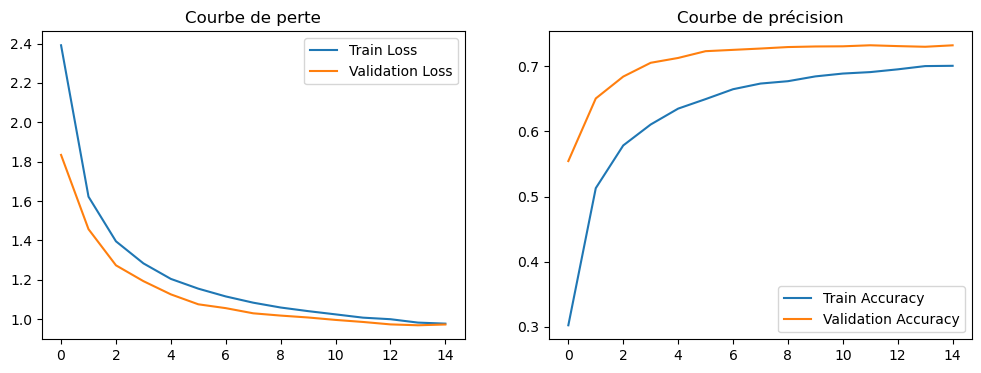

In [80]:
# Batch_size = 64 (on multiplie par 2 sa valeur)

# augmentation du dropout pour palier le surajustement
epochs = 15
dropout_rate = 0.5
embedding_dim = 40
batch_size = 64

# maj de l'architecture du modele
model = Sequential()
model.add(Embedding(input_dim = max_words, output_dim = embedding_dim, input_length = max_len))
model.add(Dropout(dropout_rate))
model.add(GlobalMaxPooling1D())
model.add(Dense(50, activation = 'relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(len(np.unique(y_train)), activation='softmax'))

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, verbose = 1, mode = 'min', 
                               restore_best_weights = True)

history = model.fit(
    X_train_pad, y_train,
    epochs = epochs,
    batch_size = batch_size,
    validation_data = (X_test_pad, y_test),
    callbacks = [early_stopping], verbose = 2)

# evaluation modèle sur les données test
score = model.evaluate(X_test_pad, y_test, verbose=1)
print("Test accuracy:", score[1])


# Visualisation des résultats
plt.figure(figsize=(12, 4))

# Tracer la courbe de perte
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Courbe de perte')
plt.legend()

# Tracer la courbe de précision
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Courbe de précision')
plt.legend()

plt.show()

Courbe de Perte :
Les courbes de perte d'entraînement et de validation montrent une diminution régulière, ce qui indique que l'augmentation de la taille du batch n'a pas nui à la capacité d'apprentissage du modèle.
Il n'y a pas d'augmentation significative de la perte de validation, ce qui suggère que le modèle ne surajuste pas.

Courbe de Précision :
La précision d'entraînement continue d'augmenter de manière stable, ce qui est un bon signe.
La précision de validation montre également une amélioration continue et ne plafonne pas, ce qui suggère que le modèle pourrait encore s'améliorer avec des ajustements supplémentaires ou plus d'époques.

Analyse Générale :
Le changement de taille de batch de 16 à 64 a légèrement réduit le temps nécessaire pour chaque époque, ce qui est avantageux en termes d'efficacité de l'entraînement.
La performance globale s'est améliorée, comme en témoigne la précision de test légèrement supérieure (environ 0.7% de plus).

--> L'augmntation de la taille du batch semble avoir un effet positif sur la performance du modèle, nous pouvons voir si en augmentant encore plus le nombre de batchs ce qui va se passer et pourquoi pas par la suite augmenter encore le nombre d'epochs en espèrant ne pas faire de surajustement.

Epoch 1/15
493/493 - 3s - loss: 2.5856 - accuracy: 0.2570 - val_loss: 2.0931 - val_accuracy: 0.4771 - 3s/epoch - 7ms/step
Epoch 2/15
493/493 - 3s - loss: 1.7846 - accuracy: 0.4766 - val_loss: 1.6068 - val_accuracy: 0.6162 - 3s/epoch - 6ms/step
Epoch 3/15
493/493 - 3s - loss: 1.5093 - accuracy: 0.5559 - val_loss: 1.4042 - val_accuracy: 0.6631 - 3s/epoch - 6ms/step
Epoch 4/15
493/493 - 3s - loss: 1.3696 - accuracy: 0.5930 - val_loss: 1.2862 - val_accuracy: 0.6834 - 3s/epoch - 6ms/step
Epoch 5/15
493/493 - 3s - loss: 1.2877 - accuracy: 0.6200 - val_loss: 1.2186 - val_accuracy: 0.6998 - 3s/epoch - 6ms/step
Epoch 6/15
493/493 - 3s - loss: 1.2228 - accuracy: 0.6363 - val_loss: 1.1628 - val_accuracy: 0.7079 - 3s/epoch - 6ms/step
Epoch 7/15
493/493 - 3s - loss: 1.1736 - accuracy: 0.6515 - val_loss: 1.1324 - val_accuracy: 0.7149 - 3s/epoch - 5ms/step
Epoch 8/15
493/493 - 3s - loss: 1.1413 - accuracy: 0.6606 - val_loss: 1.0925 - val_accuracy: 0.7217 - 3s/epoch - 5ms/step
Epoch 9/15
493/493 - 3s 

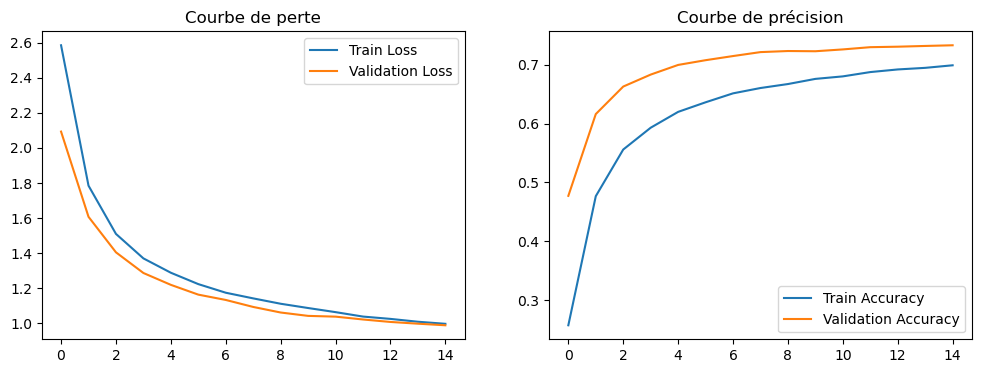

In [82]:
# Batch_size = 128

# augmentation du dropout pour palier le surajustement
epochs = 15
dropout_rate = 0.5
embedding_dim = 40
batch_size = 128

# maj de l'architecture du modele
model = Sequential()
model.add(Embedding(input_dim = max_words, output_dim = embedding_dim, input_length = max_len))
model.add(Dropout(dropout_rate))
model.add(GlobalMaxPooling1D())
model.add(Dense(50, activation = 'relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(len(np.unique(y_train)), activation='softmax'))

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, verbose = 1, mode = 'min', 
                               restore_best_weights = True)

history = model.fit(
    X_train_pad, y_train,
    epochs = epochs,
    batch_size = batch_size,
    validation_data = (X_test_pad, y_test),
    callbacks = [early_stopping], verbose = 2)

# evaluation modèle sur les données test
score = model.evaluate(X_test_pad, y_test, verbose=1)
print("Test accuracy:", score[1])


# Visualisation des résultats
plt.figure(figsize=(12, 4))

# Tracer la courbe de perte
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Courbe de perte')
plt.legend()

# Tracer la courbe de précision
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Courbe de précision')
plt.legend()

plt.show()

Courbe de Perte :
La courbe de perte d'entraînement montre une baisse rapide et stable, indiquant un apprentissage efficace.
La courbe de perte de validation diminue également et reste proche de la courbe de perte d'entraînement, suggérant que le modèle généralise bien et ne surajuste pas.

Courbe de Précision :
La précision d'entraînement continue d'augmenter au fil des époques, ce qui est un bon signe.
La précision de validation augmente également et atteint une valeur légèrement supérieure à celle observée avec une taille de batch de 64, indiquant une légère amélioration de la performance sur les données non vues.

Analyse Générale :
Augmenter la taille du batch à 68 a permis de réduire le temps par époque, ce qui peut être bénéfique pour des expériences plus rapides.
Il semble que le modèle pourrait bénéficier de tailles de batch encore plus grandes ou d'autres formes d'optimisation, étant donné que la précision de validation continue de s'améliorer sans signe de surajustement.

--> augmentons encore plus la taille du nombre de batchs, nous gagnons en plus en rapidité (résultats non concluant au niveau de l'accuracy qui est moins bonne, on a testé jusqu'à 254)

Epoch 1/15
928/928 - 5s - loss: 2.4326 - accuracy: 0.3015 - val_loss: 1.8975 - val_accuracy: 0.5471 - 5s/epoch - 5ms/step
Epoch 2/15
928/928 - 4s - loss: 1.6407 - accuracy: 0.5113 - val_loss: 1.4656 - val_accuracy: 0.6547 - 4s/epoch - 4ms/step
Epoch 3/15
928/928 - 4s - loss: 1.4094 - accuracy: 0.5749 - val_loss: 1.3011 - val_accuracy: 0.6870 - 4s/epoch - 5ms/step
Epoch 4/15
928/928 - 4s - loss: 1.2943 - accuracy: 0.6102 - val_loss: 1.2235 - val_accuracy: 0.6988 - 4s/epoch - 4ms/step
Epoch 5/15
928/928 - 4s - loss: 1.2293 - accuracy: 0.6316 - val_loss: 1.1518 - val_accuracy: 0.7088 - 4s/epoch - 4ms/step
Epoch 6/15
928/928 - 4s - loss: 1.1719 - accuracy: 0.6477 - val_loss: 1.1104 - val_accuracy: 0.7109 - 4s/epoch - 4ms/step
Epoch 7/15
928/928 - 4s - loss: 1.1372 - accuracy: 0.6581 - val_loss: 1.0724 - val_accuracy: 0.7179 - 4s/epoch - 4ms/step
Epoch 8/15
928/928 - 4s - loss: 1.1045 - accuracy: 0.6673 - val_loss: 1.0581 - val_accuracy: 0.7234 - 4s/epoch - 4ms/step
Epoch 9/15
928/928 - 4s 

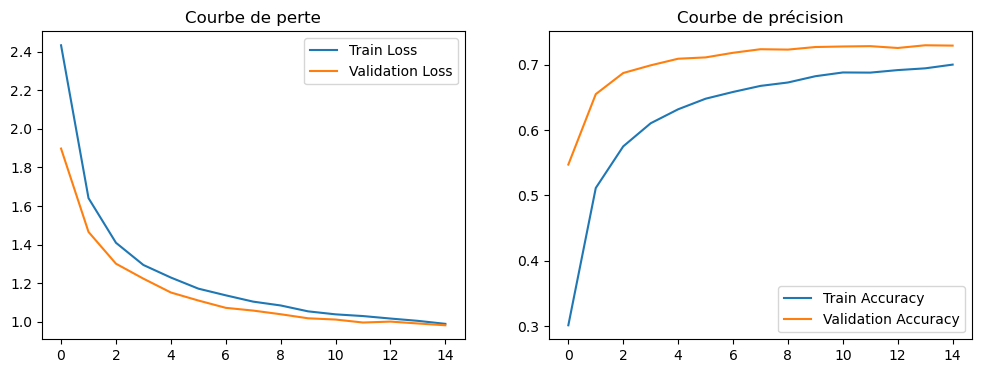

In [91]:
# Batch_size = 254

# augmentation du dropout pour palier le surajustement
epochs = 15
dropout_rate = 0.5
embedding_dim = 40
batch_size = 68

# maj de l'architecture du modele
model = Sequential()
model.add(Embedding(input_dim = max_words, output_dim = embedding_dim, input_length = max_len))
model.add(Dropout(dropout_rate))
model.add(GlobalMaxPooling1D())
model.add(Dense(50, activation = 'relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(len(np.unique(y_train)), activation='softmax'))

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, verbose = 1, mode = 'min', 
                               restore_best_weights = True)

history = model.fit(
    X_train_pad, y_train,
    epochs = epochs,
    batch_size = batch_size,
    validation_data = (X_test_pad, y_test),
    callbacks = [early_stopping], verbose = 2)

# evaluation modèle sur les données test
score = model.evaluate(X_test_pad, y_test, verbose=1)
print("Test accuracy:", score[1])


# Visualisation des résultats
plt.figure(figsize=(12, 4))

# Tracer la courbe de perte
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Courbe de perte')
plt.legend()

# Tracer la courbe de précision
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Courbe de précision')
plt.legend()

plt.show()